In [1]:
# GloVe Embeddings
!wget --no-check-certificate https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip

--2024-08-03 19:21:26--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: 'glove.6B.zip'

glove.6B.zip        100%[===================>] 822.24M  5.01MB/s    in 2m 38s  

2024-08-03 19:24:05 (5.19 MB/s) - 'glove.6B.zip' saved [862182613/862182613]



In [2]:
!unzip -q glove.6B.zip

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as thub
import keras
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
import time

import gc
gc.enable()

2024-08-03 19:24:30.402578: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-03 19:24:30.402673: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-03 19:24:30.611605: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000

In [5]:
ds, info = tfds.load('imdb_reviews', 
                     with_info=True,
                     as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete2AYCP3/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete2AYCP3/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete2AYCP3/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [6]:
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [7]:
train_ds, test_ds = ds['train'], ds['test']

In [8]:
VOCAB_SIZE = 1000
encoder = layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_ds.map(lambda text, label : text))

In [9]:
num_tokens = len(encoder.get_vocabulary()) + 2
embedding_dim = 100

In [10]:
word_index = dict(zip(encoder.get_vocabulary(), range(len(encoder.get_vocabulary()))))

In [11]:
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 993 words (7 misses)


In [12]:
embed = layers.Embedding(
    num_tokens,
    embedding_dim,
    mask_zero=True,
    trainable=False,
)
embed.build((1,))
embed.set_weights([embedding_matrix])

In [13]:
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [14]:
model = models.Sequential([
    layers.Bidirectional(tf.keras.layers.LSTM(64)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [15]:
def plot_hist(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.xlabel('Iterations')
    plt.title('Baseline Model')
    plt.legend()
    plt.show()

In [16]:
def interpolate_texts(baseline, vector, m_steps, alphas=0.01):
    delta = vector - baseline
    texts = baseline + alphas * delta
    return texts

In [17]:
def compute_gradients(t, model):
    with tf.GradientTape() as tape:
        tape.watch(t)
        probs = model(t)
    grads = tape.gradient(probs, t)
    return grads

In [18]:
def get_igs(vec_embed, model, n_steps=20):
    baseline_embed = tf.zeros(shape=tf.shape(vec_embed))
    interpolated_texts = interpolate_texts(baseline_embed, vec_embed, n_steps)
    path_gradients = compute_gradients(interpolated_texts, model)

    all_grads = tf.reduce_sum(path_gradients, axis=0) / n_steps
    x_grads = tf.math.multiply(all_grads, vec_embed)
    ig_embed = vec_embed + x_grads
    return ig_embed

In [19]:
def get_fgsm(vec_embed, model, epsilon=0.01):
    grads = compute_gradients(vec_embed, model)
    vec_embed_perturbed = vec_embed + (epsilon * grads)
    return vec_embed

In [20]:
def kpgd_perturbations(vec_embed, model, n_steps=20, alpha=0.01, epsilon=0.1):
    perturbation = tf.zeros_like(vec_embed)
    
    for _ in range(n_steps):
        with tf.GradientTape() as tape:
            tape.watch(vec_embed)
            probs = model(vec_embed + perturbation)
        grads = tape.gradient(probs, vec_embed)
        
        perturbation = tf.clip_by_value(perturbation + alpha * grads, -epsilon, epsilon)
    
    return vec_embed + perturbation

In [21]:
import keras.backend as K

In [22]:
def train_model(model, encoder, embed, train_ds, use_ig=False, use_fgsm=False, use_kpgd=False, epochs=10, data_size=10):
    K.clear_session()
    model.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=['accuracy', 'precision'])
    config = []
    
    for epoch in range(epochs):
        print(f'epoch:{epoch}')
        for text, label in train_ds.take(data_size):
            label = tf.expand_dims(label, axis=-1)
            vec = encoder(text)
            vec_embed = embed(vec)
            if use_ig:
                vec_embed = get_igs(vec_embed, model)
            if use_fgsm:
                vec_embed = get_fgsm(vec_embed, model)
            if use_kpgd:
                vec_embed = kpgd_perturbations(vec_embed, model)
            config.append(model.train_on_batch(vec_embed, label, return_dict=True))
    return (config, model)

In [23]:
start_time = time.time()
config, hist = train_model(model, encoder, embed, train_ds, use_ig=False, use_fgsm=False, use_kpgd=False)
end_time = time.time()
elapsed = end_time - start_time
print('elapsed_time:',elapsed)

epoch:0
epoch:1
epoch:2
epoch:3
epoch:4
epoch:5
epoch:6
epoch:7
epoch:8
epoch:9
elapsed_time: 49.153690814971924


In [24]:
start_time = time.time()
config_ig, hist_ig = train_model(model, encoder, embed, train_ds, use_ig=True, use_fgsm=False, use_kpgd=False)
end_time = time.time()
elapsed_ig = end_time - start_time
print('elapsed_time:',elapsed_ig)

epoch:0
epoch:1
epoch:2
epoch:3
epoch:4
epoch:5
epoch:6
epoch:7
epoch:8
epoch:9
elapsed_time: 51.52509164810181


In [25]:
start_time = time.time()
config_fgsm, hist_fgsm = train_model(model, encoder, embed, train_ds, use_ig=False, use_fgsm=True, use_kpgd=False)
end_time = time.time()
elapsed_fgsm = end_time - start_time
print('elapsed_time:',elapsed_fgsm)

epoch:0


/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'sequential' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


epoch:1
epoch:2
epoch:3
epoch:4
epoch:5
epoch:6
epoch:7
epoch:8
epoch:9
elapsed_time: 55.05913281440735


In [26]:
start_time = time.time()
config_kpgd, hist_kpgd = train_model(model, encoder, embed, train_ds, use_ig=False, use_fgsm=False, use_kpgd=True)
end_time = time.time()
elapsed_kpgd = end_time - start_time
print('elapsed_time:',elapsed_kpgd)

epoch:0
epoch:1
epoch:2
epoch:3
epoch:4
epoch:5
epoch:6
epoch:7
epoch:8
epoch:9
elapsed_time: 177.43114042282104


In [27]:
def eval_hits(model, ds, encoder, embed, steps=10):
    hits = []
    miss = []
    for text, label in ds.take(steps):
        vec = encoder(text)
        vec_embed = embed(vec)

        vec_embed_ig = get_igs(vec_embed, hist)
        pred_ig = hist.predict(vec_embed_ig, verbose=0)

        pred_ig[pred_ig<0.5] = 0
        pred_ig[pred_ig>=0.5] = 1
        pred_ig = pred_ig.astype('int64')
        pred_ig = np.squeeze(pred_ig)

        truth_ig = pred_ig == label
        hits.append(np.count_nonzero(truth_ig))
        miss.append(len(label) - np.count_nonzero(truth_ig))
            
    return hits, miss

In [28]:
def plot_hits(hits_baseline, hits_ig, hits_fgsm, hits_kpgd):
    plt.plot(hits_baseline, label='Baseline(BiLSTM)')
    plt.plot(hits_ig, label='Baseline with IG')
    plt.plot(hits_fgsm, label='Baseline with FGSM')
    plt.plot(hits_kpgd, label='Baseline with K-PGD')
    plt.xlabel('Sample')
    plt.ylabel('Number of Hit')
    plt.title('Evaluation Hits')
    plt.legend()
    plt.show()

In [29]:
def plot_miss(miss_baseline, miss_ig, miss_fgsm, miss_kpgd):
    plt.plot(miss_baseline, label='Baseline(BiLSTM)')
    plt.plot(miss_ig, label='Baseline with IG')
    plt.plot(miss_fgsm, label='Baseline with FGSM')
    plt.plot(miss_kpgd, label='Baseline with K-PGD')
    plt.title('Evaluation Miss')
    plt.xlabel('Sample')
    plt.ylabel('Number of Miss')
    plt.legend()
    plt.show()

In [30]:
def plot_loss(config_base, config_ig, config_fgsm, config_kpgd):
    loss = []
    loss_ig = []
    loss_fgsm = []
    loss_kpgd= []
    
    for param in config:
        loss.append(param['loss'])
        
    for param_ig in config_ig:
        loss_ig.append(param_ig['loss'])
    
    for param_fgsm in config_fgsm:
        loss_fgsm.append(param_fgsm['loss'])
        
    for param_kpgd in config_kpgd:
        loss_kpgd.append(param_kpgd['loss'])

    plt.plot(loss, label='Baseline(BiLSTM)')
    plt.plot(loss_ig, label='Baseline with IG')
    plt.plot(loss_fgsm, label='Baseline with FGSM')
    plt.plot(loss_kpgd, label='Baseline with K-PGD')
    plt.xlabel('Number of Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Over Training Epochs')
    plt.legend()
    plt.show()

In [31]:
def plot_acc(config_base, config_ig, config_fgsm, config_kpgd):
    acc = []
    acc_ig = []
    acc_fgsm = []
    acc_kpgd = []
    
    for param in config:
        acc.append(param['accuracy'])
        
    for param_ig in config_ig:
        acc_ig.append(param_ig['accuracy'])
    
    for param_fgsm in config_fgsm:
        acc_fgsm.append(param_fgsm['accuracy'])
        
    for param_kpgd in config_kpgd:
        acc_kpgd.append(param_kpgd['accuracy'])
        
    plt.plot(acc, label='Baseline(BiLSTM)')
    plt.plot(acc_ig, label='Baseline with IG')
    plt.plot(acc_fgsm, label='Baseline with FGSM')
    plt.plot(acc_kpgd, label='Baseline with K-PGD')
    plt.xlabel('Number of Epochs')
    plt.ylabel('Accuracy score')
    plt.title('Accuracy Over Training Epochs')
    plt.legend()
    plt.show()

In [32]:
def plot_precision(config_base, config_ig, config_fgsm, config_kpgd):
    acc = []
    acc_ig = []
    acc_fgsm = []
    acc_kpgd = []
    
    for param in config:
        acc.append(param['precision'])
        
    for param_ig in config_ig:
        acc_ig.append(param_ig['precision'])
    
    for param_fgsm in config_fgsm:
        acc_fgsm.append(param_fgsm['precision'])
        
    for param_kpgd in config_kpgd:
        acc_kpgd.append(param_kpgd['precision'])
        
    plt.plot(acc, label='Baseline(BiLSTM)')
    plt.plot(acc_ig, label='Baseline with IG')
    plt.plot(acc_fgsm, label='Baseline with FGSM')
    plt.plot(acc_kpgd, label='Baseline with K-PGD')
    plt.xlabel('Number of Epochs')
    plt.ylabel('Precision score')
    plt.title('Precision Over Training Epochs')
    plt.legend()
    plt.show()

In [33]:
hits_base, miss_base = eval_hits(hist, train_ds, encoder, embed)
hits_ig, miss_ig = eval_hits(hist_ig, train_ds, encoder, embed)
hits_fgsm, miss_fgsm = eval_hits(hist_fgsm, train_ds, encoder, embed)
hits_kpgd, miss_kpgd = eval_hits(hist_kpgd, train_ds, encoder, embed)

In [34]:
def plot_elapsed_time(elapsed_baseline, elapsed_ig, elapsed_fgsm, elapsed_kpgd):
    algorithms = ['Baseline(BiLSTM)','IG', 'FGSM', 'K-PGD']
    elapsed_times = [elapsed_baseline, elapsed_ig, elapsed_fgsm, elapsed_kpgd]

    plt.bar(algorithms, elapsed_times)
    plt.xlabel('Attack Algorithms')
    plt.ylabel('Elapsed Time (seconds)')
    plt.title('Elapsed Time for Different Attack Algorithms')
    plt.show()

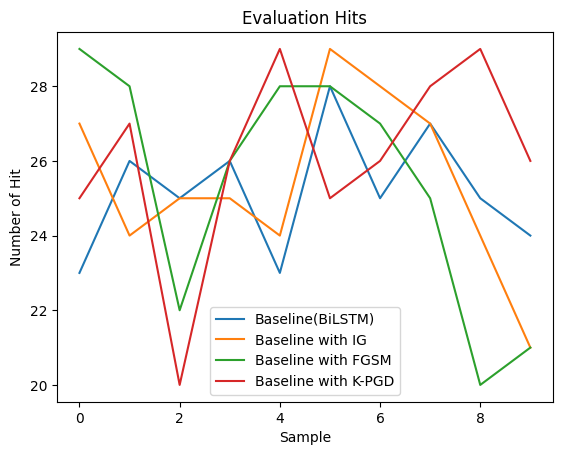

In [35]:
plot_hits(hits_base, hits_ig, hits_fgsm, hits_kpgd)

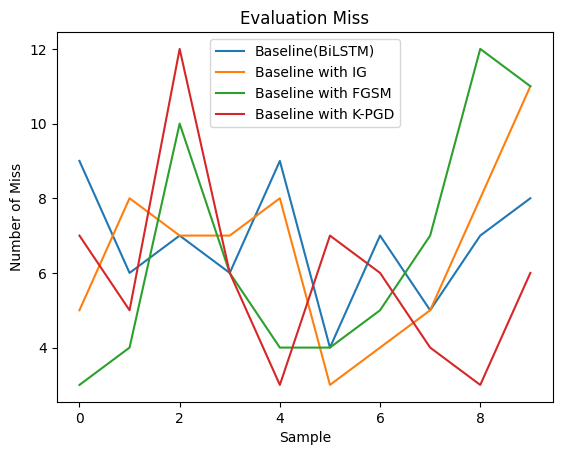

In [36]:
plot_miss(miss_base, miss_ig, miss_fgsm, miss_kpgd)

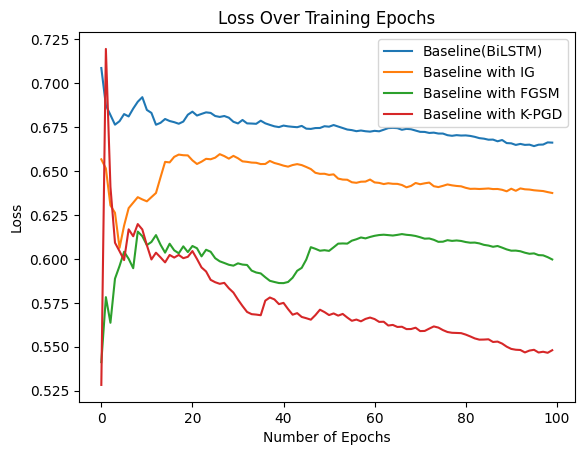

In [37]:
plot_loss(config, config_ig, config_fgsm, config_kpgd)

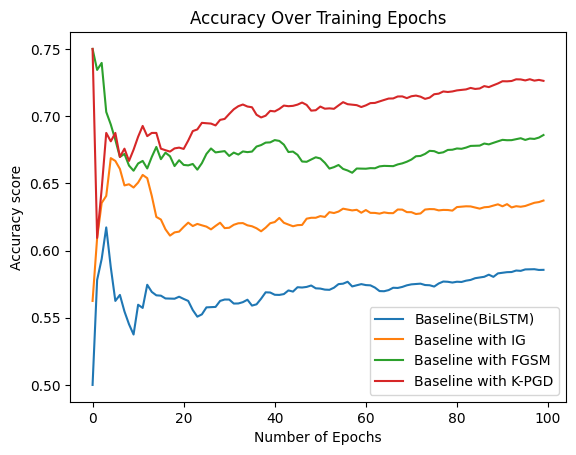

In [38]:
plot_acc(config, config_ig, config_fgsm, config_kpgd)

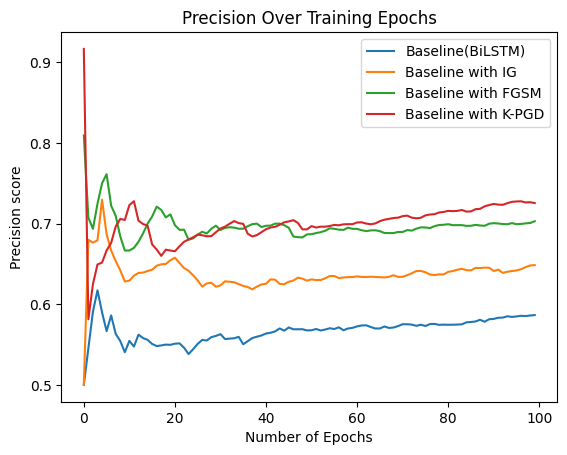

In [39]:
plot_precision(config, config_ig, config_fgsm, config_kpgd)

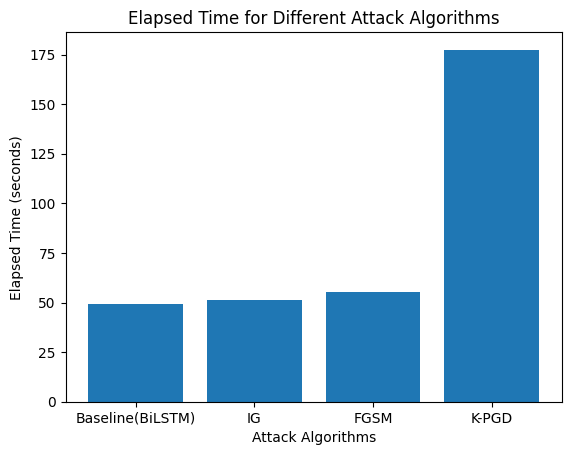

In [40]:
plot_elapsed_time(elapsed, elapsed_ig, elapsed_fgsm, elapsed_kpgd)